# 使用Tensorflow构建VGG16模型实现猫狗识别

图像识别技术可以识别出图像或者视频中的物体类别。本实验基于猫狗数据集，使用Keras手动搭建一个经典的VGG16卷积神经网络，训练一个猫狗分类模型。

## 数据集

猫狗识别数据集，猫和狗各12500张图片，图片名称中含有类别名称（cat和dog）。我们会根据图片名称中包含的类别名称（cat或dog）给图片打标签，狗的标签打成1，猫的标签打成0。

### 依赖安装

In [1]:
# !pip install --upgrade keras_applications==1.0.6 keras==2.2.4

### 导入依赖库

In [2]:
import numpy as np
from mindspore import Tensor, nn, Model 
from mindspore.train.callback import LossMonitor, CheckpointConfig, ModelCheckpoint

In [3]:
import os, cv2, random

### 下载数据集

下载数据压缩包，解压，然后清理压缩包。

In [4]:
# !wget https://modelarts-labs-bj4.obs.cn-north-4.myhuaweicloud.com/notebook/DL_image_recognition/image_recognition.tar.gz

In [5]:
import os
if not os.path.exists('./data'):
    !tar xf ./image_recognition.tar.gz
    !rm -f ./image_recognition.tar.gz

### 读取数据集

读取数据集，并把图像resize到 128 * 128 大小。

In [6]:
DATA_DIR = './data/' # 数据集路径
# from tqdm.notebook import tqdm
from tqdm import tqdm
# 目标缩放尺寸
ROWS = 224
COLS = 224
CHANNELS = 3

image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    
    for i, image_file in enumerate(tqdm(image_file_names)):
        image = read_image(image_file)
        data[i] = image
#         if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:52<00:00, 477.49it/s]


### 给图片打标签

我们根据图片名称包含的字符串给图片打标签。我们用0表示cat，1表示dog。

In [7]:
num_train_samples = len(image_file_names)
num_classes = 2 # 类别数是2
labels = []

index = 0
for filename in image_file_names:
    if 'dog' in filename:
        labels.append(1)
    elif 'cat' in filename:
        labels.append(0)
    

In [8]:
type(labels)

list

In [9]:
# 把类别标签转换为onehot编码
# labels = np_utils.to_categorical(labels, num_classes)
from mindspore.ops import operations as P

one_hot = P.OneHot()
# labels = one_hot(mindspore.Tensor(labels), num_classes)

In [10]:
import mindspore

In [11]:
depth = 2
on_value = Tensor(np.array([1.0]), mindspore.float32)
off_value = Tensor(np.array([0.0]), mindspore.float32)
result = one_hot(mindspore.Tensor(labels), depth, on_value, off_value)

In [12]:
labels=mindspore.Tensor.asnumpy(result)

In [13]:
labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### 切分数据集

（train_data，train_label）是训练数据，（test_data，test_label）是测试数据。测试数据占25%。

In [14]:
import mindspore

In [15]:
len(images)

25000

In [16]:
# import mindspore.dataset as ds

# train_data = ds.NumpySlicesDataset(images)
# train_label = ds.NumpySlicesDataset(labels)

# train_data, test_data = train_data.split([0.75, 0.25], randomize=True)
# train_label, test_label = train_label.split([0.75, 0.25], randomize=True)

In [17]:
images = np.array(images, dtype=np.float32)
images = images.transpose((0,3,1,2))

In [18]:
train_data, test_data = images[:int(len(images)*0.75)],images[int(len(images)*0.75):]
train_label, test_label = labels[:int(len(labels)*0.75)],labels[int(len(labels)*0.75):]

In [20]:
from mindspore import dataset as ds

In [21]:
train_dataset = ds.NumpySlicesDataset((train_data, train_label), ["data", "label"])
test_dataset = ds.NumpySlicesDataset((test_data, test_label), ["data", "label"])

### 查看猫狗的样本图片

这些图片是经过尺寸调整后的图片

In [22]:
import numpy as np
import matplotlib.pyplot as plt 

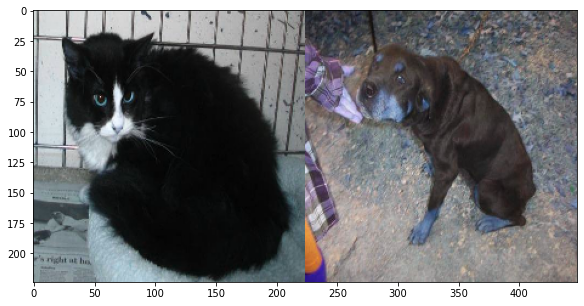

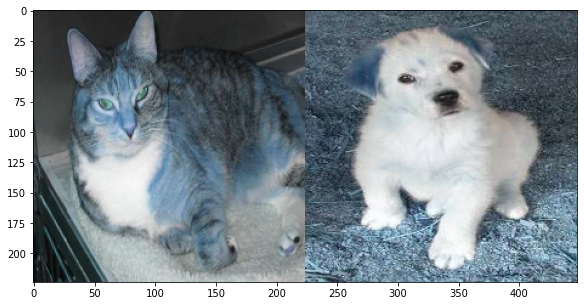

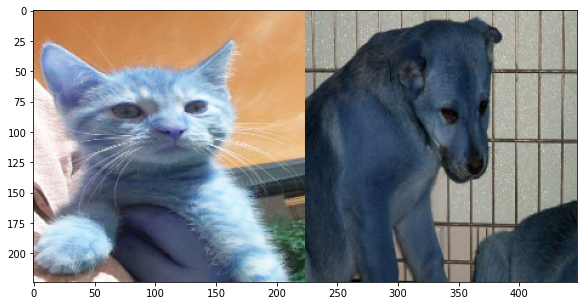

In [23]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

### 构建神经网络

Keras是一个非常简单易用的，适合新手入门的深度学习引擎。接下来，我们使用Keras搭建一个VGG16卷积神经网络。

#### 设置超参

In [24]:
batch_size = 32 # 批大小
learning_rate = 1e-5 # 设置学习率为1e-5

#### 设置优化器

In [25]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3,pad_mode='pad',padding=1,weight_init="xavier_uniform"))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,pad_mode='VALID',stride=2))
    return nn.SequentialCell(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 3
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.SequentialCell(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Dense(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Dense(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Dense(4096, 10))

net = vgg(conv_arch)

In [26]:
import mindspore as ms

x = ms.Tensor(np.zeros((1, 3, 224, 224)), ms.float32)

In [27]:
# X = ms.Tensor.rand_like(x)

In [ ]:
X = x
for blk in vgg(conv_arch):
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

In [ ]:
# optimizer = nn.Adam(lr=learning_rate) # 优化器使用 Adam 
# loss_fn=nn.loss.SoftmaxCrossEntropyWithLogits() # loss 函数使用交叉熵

class MyModel(nn.Cell):
    def __init__(self):
        super(MyModel, self).__init__()
        self.base_model = vgg(conv_arch)
        self.fc = nn.Dense(10,2)

    def construct(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x
net = MyModel()
loss = nn.SoftmaxCrossEntropyWithLogits()
optim = nn.Momentum(params=net.trainable_params(), learning_rate=learning_rate, momentum=0.9)
model = Model(net, loss_fn=loss, optimizer=optim, metrics={'acc'})

# model = Model(MyModel(), loss_fn=nn.loss.SoftmaxCrossEntropyWithLogits(), optimizer=nn.Adam(lr=learning_rate), metrics=)

### 模型结构概览

可以查看到刚刚搭建的神经网络结构的详情。

In [ ]:
model._network

### 模型训练

在模型训练过程中，为了防止过拟合，我们使用了early stopping策略，当val_loss在连续3个epoch不再减少的情况下，就停止训练。

本案例训练15轮，大概耗费10分钟。

可以看到训练日志输出，其中会打印Loss（损失函数）和acc（精确度）信息。

In [ ]:
from mindspore.train import EarlyStopping

In [ ]:
# fit(epoch, train_dataset, valid_dataset=None, valid_frequency=1, callbacks=None, 
#     dataset_sink_mode=False, valid_dataset_sink_mode=False, sink_size=-1, initial_epoch=0)

In [ ]:
train_dataset = ds.NumpySlicesDataset((train_data, train_label), ["data", "label"])
test_dataset = ds.NumpySlicesDataset((test_data, test_label), ["data", "label"])

In [ ]:
train_dataset = train_dataset.batch(batch_size=128)
test_dataset = test_dataset.batch(batch_size=128)

In [ ]:
for item in train_dataset:
    item[0].shape
    break

In [ ]:
item[0].shape

In [ ]:
epochs = 1 # 训练轮数

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=True, mode='auto',restore_best_weights=True)   

def run_train():
    
    # 开始训练
    history = model.fit(
        epoch= epochs,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        valid_frequency=1,
        callbacks=[early_stopping],
#         batch_size=batch_size, 
#         epoch=epochs,
#         validation_split=0.2,  # 训练数据中，抽取20%的数据作为验证数据
#         verbose=1,
#         shuffle=True,
        ) 
    return history

history = run_train()

In [ ]:
history

### 保存模型

训练好的模型可以保存起来，永久使用。

In [ ]:
OUTPUT = 'output'

if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)

model.save(os.path.join(OUTPUT, 'model.h5'))

### 可视化训练过程

将Loss随epoch的变化趋势使用折线图展示

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

将accurary随epoch的变化趋势使用折线图展示

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('VGG-16 acc Trend')
plt.plot(acc, 'blue', label='Training acc')
plt.plot(val_acc, 'green', label='Validation acc')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

### 样本数据预测

预测测试集

In [ ]:
predictions = model.predict(test_data, verbose=0)

直观展示10个样本数据的预测结果

In [ ]:
for i in range(0,10):
    p = predictions[i]
    
    if round(p[1]) == 1: 
        print('I am {:.2%} sure this is a Dog'.format(p[1]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1 - p[1]))
        
    plt.imshow(test_data[i])
    plt.show()

### 评估模型准确度

通过测试集的预测结果，计算模型的准确度。

In [ ]:
predictions_test_array = []
test_label_array = []

# 将onehot编码的数据进行格式转换
for p in predictions:
    if round(p[1]) == 1:
        predictions_test_array.append(1)
    else:
        predictions_test_array.append(0)
        
for t in test_label:
    if int(t[1]) == 1:
        test_label_array.append(1)
    else:
        test_label_array.append(0)
        
acc = accuracy_score(test_label_array, predictions_test_array)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

## 总结

本Notebook使用Keras搭建了一个VGG16神经网络，并使用猫狗数据集训练了一个猫狗识别模型。